In [ ]:
#Inspirado en:
# https://www.youtube.com/watch?v=ZMudJXhsUpY&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=6

# Instalación e importacion de bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.layers import Input, Concatenate, Dot, RepeatVector, TimeDistributed, Multiply
from tensorflow.keras.layers import Bidirectional, LSTM, Activation, Reshape, Lambda, Dropout, GRU, SimpleRNN
from tensorflow.keras.utils import plot_model, to_categorical, pad_sequences
import tensorflow.keras.callbacks as callbacks

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Preparación de datasets

## División de txt en arreglo de párrafos

In [3]:
filepath= '/content/drive/My Drive/Dr. Jekyll and Mr. Hyde.txt'

with open(filepath, 'r') as file:
    text = file.read()

text = text.replace("Mr.","Mr").replace("Dr.","Dr").replace(".", " SEP ")
parrafos = text.lower().split('\n\n') # Dividir el contenido en párrafos

# Eliminamos enters y agregamos SOS y EOS
dataset = ["< "+parrafo.strip().replace('\n', ' ')+" >" for parrafo in parrafos if parrafo !=""]

In [4]:
dataset[10]

'< “i see you feel as i do,” said mr enfield sep  “yes, it’s a bad story sep  for my man was a fellow that nobody could have to do with, a really damnable man; and the person that drew the cheque is the very pink of the proprieties, celebrated too, and (what makes it worse) one of your fellows who do what they call good sep  blackmail, i suppose; an honest man paying through the nose for some of the capers of his youth sep  black mail house is what i call the place with the door, in consequence sep  though even that, you know, is far from explaining all,” he added, and with the words fell into a vein of musing sep >'

In [5]:
corpus_size = len(dataset)
corpus_size

349

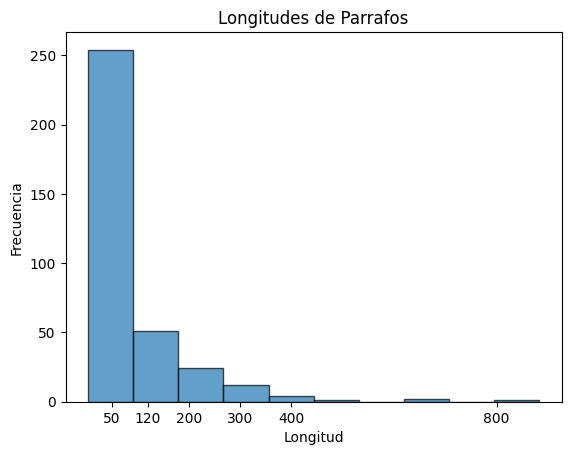

In [6]:
longitudes = [len(texto.split()) for texto in dataset]

bin_edges = plt.hist(longitudes, bins=10, edgecolor='k', alpha=0.7)
plt.xticks([50,120,200,300,400,800], ['50','120','200','300','400','800'])

plt.title('Longitudes de Parrafos')
plt.xlabel('Longitud')
plt.ylabel('Frecuencia')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
trainset, testset, _, _= train_test_split(dataset, range(corpus_size), test_size=0.05, random_state=42, shuffle=True)

trainset[0]

'< “good god!” thought mr utterson, “can he, too, have been thinking of the will?” but he kept his feelings to himself and only grunted in acknowledgment of the address sep >'

## Tokenizacion de textos

In [8]:
from keras.preprocessing.text import Tokenizer

token=Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)

token.fit_on_texts(dataset)

dictionary = token.index_word
vocab_size=len(dictionary)+1

In [9]:
dictionary

{1: 'the',
 2: 'sep',
 3: 'and',
 4: 'of',
 5: 'to',
 6: 'a',
 7: 'i',
 8: 'was',
 9: 'in',
 10: '”',
 11: 'he',
 12: 'that',
 13: '<',
 14: '>',
 15: 'it',
 16: 'my',
 17: 'his',
 18: 'with',
 19: 'had',
 20: 'you',
 21: 'as',
 22: 'but',
 23: 'for',
 24: 'at',
 25: 'on',
 26: 'this',
 27: 'is',
 28: 'said',
 29: 'be',
 30: 'utterson',
 31: 'by',
 32: 'have',
 33: 'me',
 34: 'mr',
 35: 'not',
 36: 'him',
 37: 'from',
 38: 'which',
 39: 'hyde',
 40: 'were',
 41: 'all',
 42: 'when',
 43: 'an',
 44: 'more',
 45: 'so',
 46: 'man',
 47: 'one',
 48: 'out',
 49: 'jekyll',
 50: '“i',
 51: 'there',
 52: 'no',
 53: 'if',
 54: 'lawyer',
 55: 'been',
 56: 'will',
 57: 'what',
 58: 'upon',
 59: 'now',
 60: 'poole',
 61: 'like',
 62: 'into',
 63: 'very',
 64: 'or',
 65: 'sir',
 66: 'would',
 67: 'then',
 68: 'your',
 69: 'door',
 70: 'these',
 71: 'could',
 72: 'life',
 73: 'up',
 74: 'some',
 75: 'they',
 76: 'see',
 77: 'even',
 78: 'hand',
 79: 'once',
 80: 'know',
 81: 'before',
 82: 'good',
 8

In [10]:
vocab_size

4155

In [11]:
def genSequences(token, text_set, max_len=500):
  x_sequences = []
  y_sequences = []

  tokenized = token.texts_to_sequences(text_set)  # Tokenizo los textos

  # Armo secuencias de largo max_len o menor
  for text in tokenized:
    for i in range(1, len(text)):
      x_sequences.append(text[:i])  # Arreglos de entrada
      y_sequences.append(text[i])   # Arreglos de salida

  x_sequences = pad_sequences(x_sequences, maxlen=max_len, padding='pre', truncating='pre')
  y_sequences = to_categorical(y_sequences, num_classes=len(token.index_word)+1)

  return x_sequences, y_sequences

In [12]:
max_len=500

x_train, y_train = genSequences(token, trainset, max_len=max_len)
x_test, y_test = genSequences(token, testset, max_len=max_len)

In [13]:
print(token.sequences_to_texts([x_train[10][-15:]])[0])
x_train[10][-15:]

< “good god ” thought mr utterson “can he too have


array([   0,    0,    0,    0,   13,  955,  187,   10,   89,   34,   30,
       2185,   11,  151,   32], dtype=int32)

# Embeddings

In [14]:
import codecs

embedding_dim=300               # Dato de FastText
embedding_matrix=np.zeros([vocab_size,embedding_dim])

embed_path='/content/drive/My Drive/wiki-news-300d-1M.vec'

#carga de embeddings externos
f = codecs.open(embed_path, encoding='utf-8')

for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')

    # Armamos la matriz de embeddings en base a nuestro vocab
    if word in token.index_word.values():
      idx = next((idx for idx, dict_word in token.index_word.items() if dict_word == word), None)
      if idx != None:
        embedding_matrix[idx,:] = coefs

f.close()

np.save('/content/drive/My Drive/Jekyllembeed.npy', embedding_matrix)

## Carga de matriz ya ordenada

In [14]:
embedding_dim=300               # Dato de FastText
embedding_matrix=np.zeros([vocab_size,embedding_dim])

embedding_matrix = np.load('/content/drive/My Drive/Jekyllembeed.npy')

In [15]:
print("Tamaño vocabulario: ", vocab_size)
print("Dim matriz de embeddings: ", embedding_matrix.shape)

Tamaño vocabulario:  4155
Dim matriz de embeddings:  (4155, 300)


# Metricas de generación

Métricas de Calidad del Texto:

* **Perplejidad**: La perplejidad mide **cuán bien un modelo de lenguaje puede predecir una secuencia de palabras** en función de su entrenamiento. Cuanto más bajo sea el valor de perplejidad, mejor es la calidad del texto, ya que indica que el modelo puede predecir con precisión las palabras siguientes en la secuencia. Se utiliza en la evaluación de modelos de lenguaje para evaluar la calidad de la generación de texto

* **BLEU** (Bilingual Evaluation Understudy): es una métrica comúnmente utilizada para evaluar la **calidad de la traducción automática y la generación de texto**. Compara la similitud de n-gramas (secuencias de palabras) generados por el modelo con las secuencias de palabras de referencia. Cuanto más cercanos sean los n-gramas generados a las referencias, mayor será el puntaje BLEU. Muy utilizado en la evaluación automática de sistemas de traducción automática y generación de resúmenes, entre otros

* **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation): se enfoca en medir la similitud entre palabras y frases del texto generado y las de referencia. Puede incluir métricas como ROUGE-1 (unigramas), ROUGE-2 (bigramas), y ROUGE-L (la longitud de la secuencia común más larga). Se utiliza en la evaluación de resúmenes automáticos y generación de texto. Cuanto más alto sea el puntaje ROUGE, mejor será la calidad del texto generado.

En esta aplicación utilizaremos la ***perplejidad*** cuya fórmula utilizada fue:

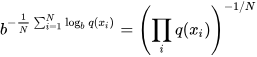

In [24]:
def calcPerplexity(text_set, token, model, max_len=500):
  perp = np.array([])

  for text in text_set:
    text_perp = 1
    x_tokenized, y_tokenized = genSequences(token, [text]) # Tokenizo y paddeo

    # Hago las predicciones para los diferentes largos
    probs = model.predict(pad_sequences(x_tokenized, maxlen=max_len), verbose=0)

    # Calculo de la productoria
    for i in range(1, len(y_tokenized)):
      text_perp *= probs[i][np.argmax(y_tokenized[i])]

    perp = np.append(perp, text_perp ** (-1/len(y_tokenized)))

  return np.mean(perp)

# Modelos

In [17]:
def softMaxOverTime(x):
    return tf.keras.activations.softmax(x,axis=1)

## LSTM

### Arquitectura

In [27]:
LSTM_dim=100

input_layer = Input(shape=(max_len,))

# Embeddings pre entrenados
#embedding_layer=Embedding(input_dim=vocab_size, output_dim=embedding_dim,
#                          weights=[embedding_matrix], input_length=max_len,
#                          trainable=False, mask_zero=True)(input_layer)

embedding_layer=Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                          weights=[embedding_matrix], input_length=max_len,
                          trainable=False)(input_layer)

lstm_out=Bidirectional(LSTM(LSTM_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)
ulog_attention=Dense(1,activation="linear")(lstm_out)

attention=Activation(softMaxOverTime)(ulog_attention)
#repeated_attention = tf.tile(attention, [1,1,LSTM_dim])
repeated_attention=TimeDistributed(RepeatVector(LSTM_dim))(attention)
repeated_attention=Reshape([max_len,LSTM_dim])(repeated_attention)

weighted_embeddings=Multiply()([repeated_attention,lstm_out])
embedding_sum = Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(weighted_embeddings)

dense0=Dense(vocab_size//16, activation='relu')(embedding_sum)
dense1=Dense(vocab_size//4, activation='relu')(dense0)
dense2=Dense(vocab_size, activation='softmax')(dense1)

model=Model(input_layer , dense2)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 500, 300)             1246500   ['input_3[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 500, 100)             320800    ['embedding_2[0][0]']         
 onal)                                                                                            
                                                                                                  
 dense_5 (Dense)             (None, 500, 1)               101       ['bidirectional_2[0][0]'

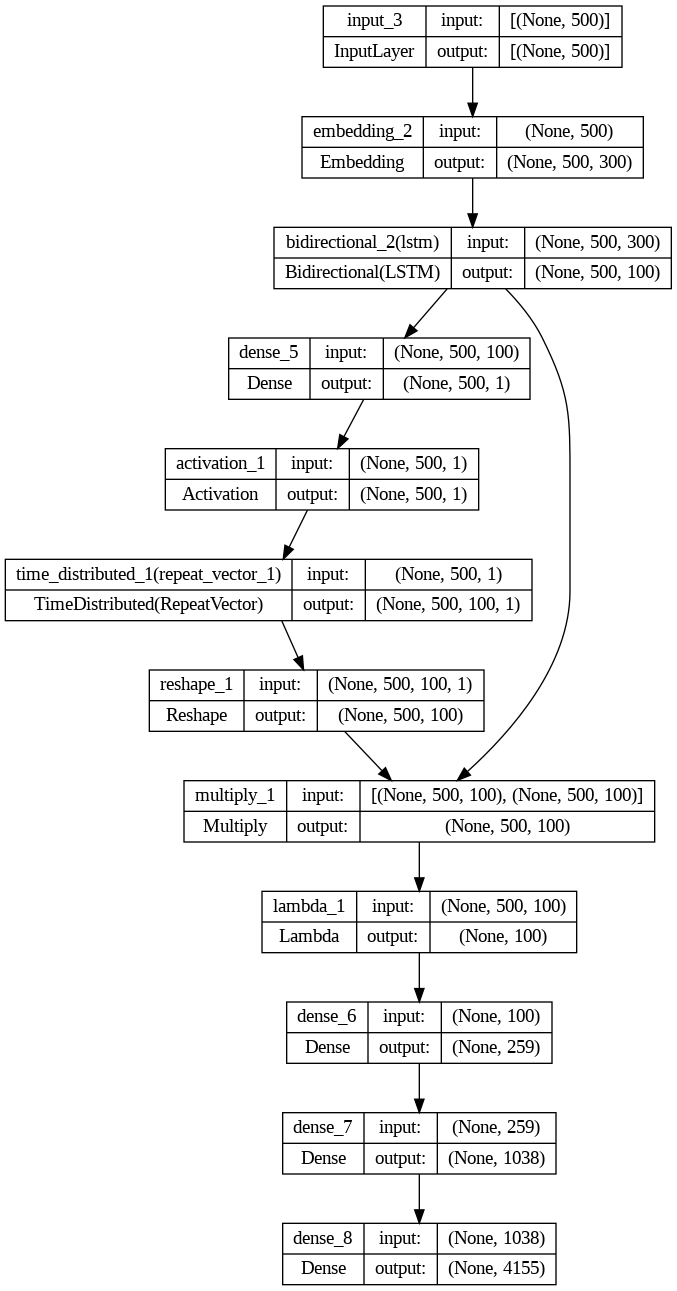

In [28]:
plot_model(model, "LM_LSTM.png", show_shapes=True)

In [29]:
adam = tf.keras.optimizers.Adam(learning_rate=2e-3)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### Entrenamiento

In [23]:
file = "/content/drive/MyDrive/JekyllLSTM.h5"

BATCH_SIZE = 256

early_cb = callbacks.EarlyStopping(monitor="accuracy", min_delta=1e-3, patience=10,
                                   start_from_epoch=20)

plateu_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor="accuracy", factor=0.05,
                                          patience=10)

In [50]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=50, validation_split=0.1, callbacks=[early_cb, plateu_cb])

Epoch 1/50
92/92 [==============================] - 19s 140ms/step - loss: 6.6368 - accuracy: 0.0481 - val_loss: 6.4397 - val_accuracy: 0.0534 - lr: 0.0020
Epoch 2/50
92/92 [==============================] - 12s 132ms/step - loss: 6.2531 - accuracy: 0.0587 - val_loss: 6.4907 - val_accuracy: 0.0546 - lr: 0.0020
Epoch 3/50
92/92 [==============================] - 12s 133ms/step - loss: 6.1845 - accuracy: 0.0597 - val_loss: 6.4928 - val_accuracy: 0.0550 - lr: 0.0020
Epoch 4/50
92/92 [==============================] - 12s 135ms/step - loss: 6.0971 - accuracy: 0.0598 - val_loss: 6.4745 - val_accuracy: 0.0561 - lr: 0.0020
Epoch 5/50
92/92 [==============================] - 12s 134ms/step - loss: 5.9988 - accuracy: 0.0611 - val_loss: 6.4917 - val_accuracy: 0.0642 - lr: 0.0020
Epoch 6/50
92/92 [==============================] - 13s 137ms/step - loss: 5.8198 - accuracy: 0.0679 - val_loss: 6.3265 - val_accuracy: 0.0754 - lr: 0.0020
Epoch 7/50
92/92 [==============================] - 13s 139ms/st

#### Mask_zeros = True
Probamos la utilización de la máscara para tokens nulos. Su extrema demora en entrenamiento hizo que no terminemos utilizandola.

In [22]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=50, callbacks=[early_cb])

Epoch 1/50
102/102 [==============================] - 277s 3s/step - loss: 6.6397 - accuracy: 0.0550
Epoch 2/50
 41/102 [===========>..................] - ETA: 2:35 - loss: 6.1316 - accuracy: 0.0601

KeyboardInterrupt: ignored

### Guardado de modelo y pesos entrenados

In [40]:
model.save("/content/drive/MyDrive/JekyllLSTM.h5")

### Carga de modelo y pesos ya entrenados

In [30]:
# Loads the weights
file = "/content/drive/MyDrive/JekyllLSTM.h5"
model.load_weights(file)

### Testeo

In [31]:
print("Perplexity:", calcPerplexity(trainset[::3], token, model))

Perplexity: 1.31820877836301


## GRU

### Arquitectura

In [18]:
LSTM_dim=100

input_layer = Input(shape=(max_len,))

embedding_layer=Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                          weights=[embedding_matrix], input_length=max_len,
                          trainable=False)(input_layer) # Embeddings pre entrenados

lstm_out=Bidirectional(GRU(LSTM_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)
ulog_attention=Dense(1,activation="linear")(lstm_out)

attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(LSTM_dim))(attention)
repeated_attention=Reshape([max_len,LSTM_dim])(repeated_attention)

weighted_embeddings=Multiply()([repeated_attention,lstm_out])
embedding_sum = Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(weighted_embeddings)

dense0=Dense(vocab_size//16, activation='relu')(embedding_sum)
dense1=Dense(vocab_size//4, activation='relu')(dense0)
dense2=Dense(vocab_size, activation='softmax')(dense1)

modelGRU=Model(input_layer , dense2)

modelGRU.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 500, 300)             1246500   ['input_2[0][0]']             
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 500, 100)             241200    ['embedding_1[0][0]']         
 onal)                                                                                            
                                                                                                  
 dense_1 (Dense)             (None, 500, 1)               101       ['bidirectional_1[0][0]'] 

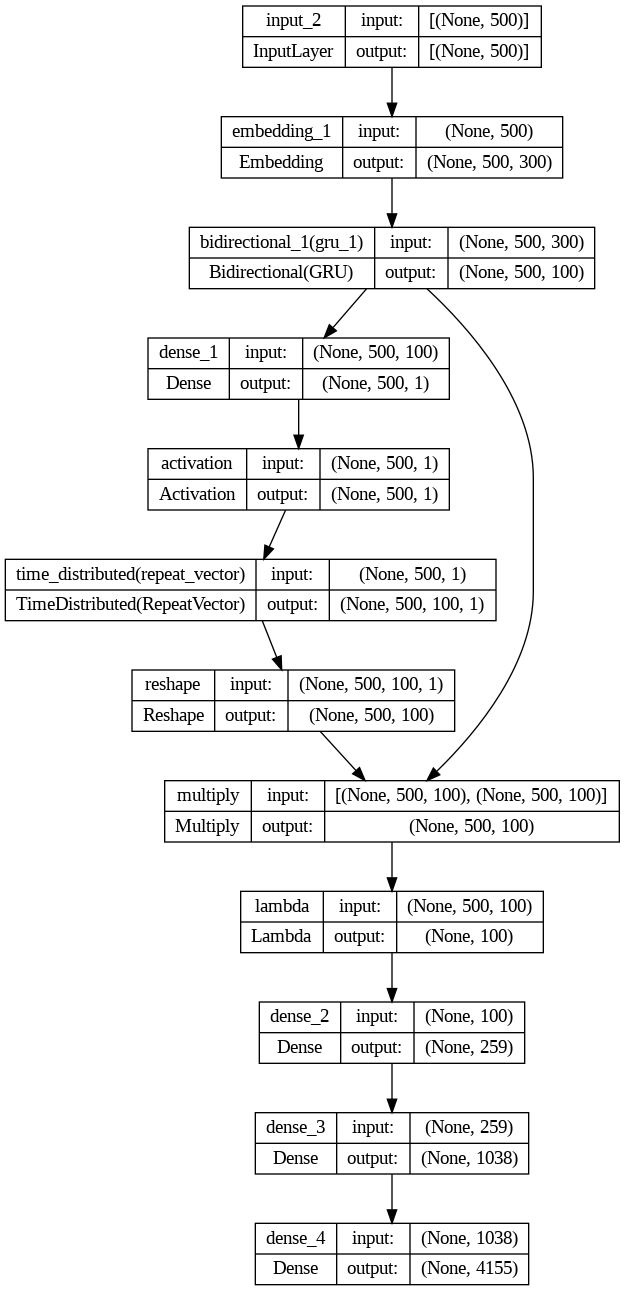

In [19]:
plot_model(modelGRU, "LM_GRU.png", show_shapes=True)

In [20]:
adamGRU = tf.keras.optimizers.Adam(learning_rate=5e-3)
modelGRU.compile(loss='categorical_crossentropy', optimizer=adamGRU, metrics=['accuracy'])

### Entrenamiento

In [56]:
BATCH_SIZE = 256
early_cb = callbacks.EarlyStopping(monitor="accuracy", min_delta=1e-3, patience=10,
                                   start_from_epoch=20)

In [57]:
historyGRU = modelGRU.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=40, callbacks=[early_cb])

Epoch 1/40
102/102 [==============================] - 17s 122ms/step - loss: 6.6649 - accuracy: 0.0528
Epoch 2/40
102/102 [==============================] - 13s 123ms/step - loss: 6.2325 - accuracy: 0.0582
Epoch 3/40
102/102 [==============================] - 13s 125ms/step - loss: 6.1115 - accuracy: 0.0618
Epoch 4/40
102/102 [==============================] - 13s 123ms/step - loss: 5.8266 - accuracy: 0.0818
Epoch 5/40
102/102 [==============================] - 12s 122ms/step - loss: 5.4509 - accuracy: 0.1111
Epoch 6/40
102/102 [==============================] - 12s 122ms/step - loss: 5.1340 - accuracy: 0.1360
Epoch 7/40
102/102 [==============================] - 12s 122ms/step - loss: 4.8721 - accuracy: 0.1483
Epoch 8/40
102/102 [==============================] - 12s 122ms/step - loss: 4.6344 - accuracy: 0.1606
Epoch 9/40
102/102 [==============================] - 12s 122ms/step - loss: 4.3941 - accuracy: 0.1674
Epoch 10/40
102/102 [==============================] - 12s 122ms/step - l

### Guardado de modelo y pesos entrenados

In [59]:
modelGRU.save("/content/drive/MyDrive/JekyllGRU.h5")

### Carga de modelo y pesos ya entrenados

In [21]:
modelGRU.load_weights("/content/drive/MyDrive/JekyllGRU.h5")

### Testeo

In [25]:
print("Perplexity:", calcPerplexity(trainset[::3], token, modelGRU))

Perplexity: 1.480890912901461


## SimpleRNN

### Arquitectura

In [75]:
LSTM_dim=100

input_layer = Input(shape=(max_len,))

embedding_layer=Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                          weights=[embedding_matrix], input_length=max_len,
                          trainable=False)(input_layer) # Embeddings pre entrenados

lstm_out=Bidirectional(SimpleRNN(LSTM_dim, return_sequences=True, activation="tanh"), merge_mode="sum")(embedding_layer)
ulog_attention=Dense(1,activation="linear")(lstm_out)

attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(LSTM_dim))(attention)
repeated_attention=Reshape([max_len,LSTM_dim])(repeated_attention)

weighted_embeddings=Multiply()([repeated_attention,lstm_out])
embedding_sum = Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(weighted_embeddings)

dense0=Dense(vocab_size//16, activation='relu')(embedding_sum)
dense1=Dense(vocab_size//4, activation='relu')(dense0)
dense2=Dense(vocab_size, activation='softmax')(dense1)

modelRNN=Model(input_layer , dense2)

modelRNN.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 500, 300)     1246500     ['input_8[0][0]']                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 500, 100)    80200       ['embedding_7[0][0]']            
 )                                                                                                
                                                                                                  
 dense_24 (Dense)               (None, 500, 1)       101         ['bidirectional_6[0][0]']  

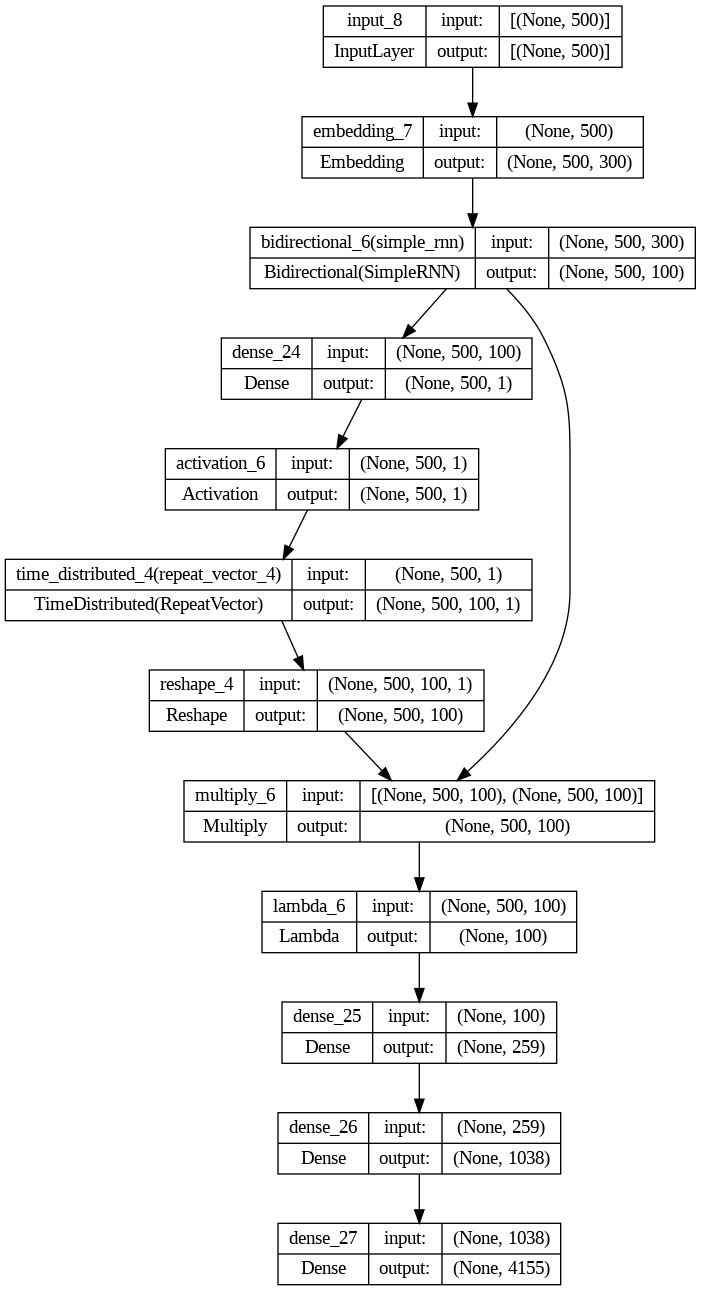

In [76]:
plot_model(modelRNN, "LM_RNN.png", show_shapes=True)

In [77]:
adamRNN = tf.keras.optimizers.Adam(learning_rate=5e-3)
modelRNN.compile(loss='categorical_crossentropy', optimizer=adamRNN, metrics=['accuracy'])

### Entrenamiento

In [78]:
BATCH_SIZE = 256
early_cb = callbacks.EarlyStopping(monitor="accuracy", min_delta=1e-3, patience=10,
                                   start_from_epoch=20)

In [79]:
historyRNN = modelRNN.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=40, callbacks=[early_cb])

Epoch 1/40
102/102 [==============================] - 102s 972ms/step - loss: 6.4576 - accuracy: 0.0495
Epoch 2/40
102/102 [==============================] - 99s 974ms/step - loss: 5.9777 - accuracy: 0.0816
Epoch 3/40
102/102 [==============================] - 99s 962ms/step - loss: 5.5622 - accuracy: 0.1117
Epoch 4/40
102/102 [==============================] - 104s 1s/step - loss: 5.2360 - accuracy: 0.1291
Epoch 5/40
102/102 [==============================] - 100s 970ms/step - loss: 5.0023 - accuracy: 0.1362
Epoch 6/40
102/102 [==============================] - 100s 977ms/step - loss: 4.8164 - accuracy: 0.1423
Epoch 7/40
102/102 [==============================] - 99s 978ms/step - loss: 4.6649 - accuracy: 0.1462
Epoch 8/40
102/102 [==============================] - 100s 978ms/step - loss: 4.5231 - accuracy: 0.1525
Epoch 9/40
102/102 [==============================] - 102s 1s/step - loss: 4.4076 - accuracy: 0.1528
Epoch 10/40
102/102 [==============================] - 100s 979ms/step - 

KeyboardInterrupt: ignored

### Guardado de modelo y pesos entrenados

In [ ]:
modelRNN.save("/content/drive/MyDrive/JekyllRNN.h5")

### Carga de modelo y pesos ya entrenados

In [ ]:
modelRNN.load_weights("/content/drive/MyDrive/JekyllRNN.h5")

### Testeo

In [ ]:
print("Perplexity:", calcPerplexity(trainset[::3], token, modelRNN))

Jekyll said you sir indeed ” returned the butler “i i knew it ” and the next moment for that masked point from his mind misgives was


# Funciones de generación

## Greedy Search + ArgMax

In [33]:
def greedy(seed_phrase, token, model, pred_len=25, max_len=500, stopper="> sep"):
  stop_token = token.texts_to_sequences([stopper])[0]
  seed_text = token.texts_to_sequences([seed_phrase])[0]
  pred_arr = []

  for _ in range(pred_len):
    # Concatenamos y paddeamos
    aux = np.concatenate((seed_text, pred_arr))
    padded = pad_sequences([aux], maxlen=max_len)

    # Predecimos
    pred_idx = np.argmax(model.predict(padded, verbose=0)[0])

    if pred_idx in stop_token:  # La prediccion hasta un stop_char
      break

    pred_arr = np.append(pred_arr, [int(pred_idx)])


  return token.sequences_to_texts([pred_arr])[0]

In [34]:
seed= "Jekyll"
prediction = greedy(seed, token, model, pred_len=25)
print(seed, prediction)

Jekyll he he told so enough came to that the maid entered with his hands and their own eyes at the name and this went so


## Greedy Search + Temperatura

In [61]:
import random

def greedyTemp(seed_phrase, token, model, temp=1, pred_len=25, max_len=500, stopper=[">", "sep"]):
  stop_token = token.texts_to_sequences(stopper)[0]
  seed_text = token.texts_to_sequences([seed_phrase])[0]
  pred_arr = []

  for _ in range(pred_len):
    # Concatenamos y paddeamos
    aux = np.concatenate((seed_text, pred_arr))
    padded = pad_sequences([aux], maxlen=max_len)

    # Predecimos considerando temperatura y elegimos de forma semialeatoria
    probs = (model.predict(padded, verbose=0)[0])**(1/temp)
    pred_idx = random.choices(range(len(probs)), weights=probs, k=1)

    if pred_idx in stop_token:
      break

    # Agregamos el nuevo token a la prediccion
    pred_arr = np.append(pred_arr, [pred_idx])

  return token.sequences_to_texts([pred_arr])[0]

In [63]:
seed= "Jekyll"
prediction = greedyTemp(seed, token, model, temp=1.25, pred_len=25)
print(seed, prediction)

Jekyll that was to shine on the middle of whose such these two base were long ago resolved the church—till name that was not chemical mine


## Stochastic Beam Search

In [64]:
import numpy as np
import random

def stochastic_beam_search(seed_phrase, token, n_beam=3, temp=1.0, pred_len=20):
    seqs = token.texts_to_sequences([seed_phrase])
    probs = [1]

    for paso in range(pred_len):
        new_seqs = []
        new_probs = []

        for i in range(len(seqs)):
            padded = pad_sequences([seqs[i]], maxlen=max_len)
            # Generar prediccion y aplicar temp
            pred_probs = (model.predict(padded, verbose=0)[0])**(1/temp)

            # Elegir N opciones en base a sus probs
            pred_idx = random.choices(range(len(pred_probs)), weights=pred_probs, k=n_beam)

            # Appendear token predichos y sus probs calculadas
            for idx in pred_idx:
              new_seqs.append(seqs[i]+[idx])
              new_probs.append(probs[i]*pred_probs[idx])

        # Actualizamos
        seqs = new_seqs
        probs = new_probs

    likely_idx = probs.index(max(probs)) # Me quedo con la opcion mas probable

    #Devuelvo la prediccion (sin la seed) en formato texto
    return token.sequences_to_texts([seqs[likely_idx]])[0]

In [71]:
seed= "Jekyll cry"
prediction = stochastic_beam_search(seed, token, n_beam=3, temp=1, pred_len=5)
print(prediction)

jekyll cry as he did not see


In [72]:
seed= "Jekyll cry"
prediction = stochastic_beam_search(seed, token, n_beam=3, temp=2, pred_len=5)
print(prediction)

jekyll cry out upon the court and
